In [56]:
import nltk
import nltk 
# nltk.download('stopwords')               #use only first time 
import re                                  # library for regular expression operations\
import string                              # for string operations\
from nltk.corpus import stopwords          # module for stop words that come with NLTK\
from nltk.stem import PorterStemmer        # module for stemming\
from nltk.tokenize import TweetTokenizer
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.optimizers import Adam

In [14]:
df = pd.read_csv('Twitter_Data.csv', index_col=False)
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [256]:
# y=pd.DataFrame(y).info()
y=df['category'].fillna(0.0)

y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 162980 entries, 0 to 162979
Series name: category
Non-Null Count   Dtype  
--------------   -----  
162980 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


## PreProcess the Text
       Remove hyperlinks
       Remove hashtags
       Tokenizer class
       Stop word and punctuation

In [17]:
x= df['clean_text']
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
stopwords_english = stopwords.words('english')
ps = PorterStemmer()
cleanList=[]
for i in x:
    # Remove  hyperLink
    i = re.sub(r'https?://[^\\s\\n\\r]+', '', str(i))
    # Remove Hastag
    i = re.sub(r'#', '', i)
    # Lowercase
    i = i.lower()
    # Tokenizer
    tweet_tokens = tokenizer.tokenize(i)
    # stopword and puncuation
    tweets_clean=[]
    for word in tweet_tokens: # Go through every word in your tokens list\
        if (word not in stopwords_english and  word not in string.punctuation):
                tweets_clean.append(ps.stem(word))
    cleanList.append(tweets_clean)
print(cleanList[:5])    

[['modi', 'promis', '“', 'minimum', 'govern', 'maximum', 'govern', '”', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ'], ['talk', 'nonsens', 'continu', 'drama', 'vote', 'modi'], ['say', 'vote', 'modi', 'welcom', 'bjp', 'told', 'rahul', 'main', 'campaign', 'modi', 'think', 'modi', 'relax'], ['ask', 'support', 'prefix', 'chowkidar', 'name', 'modi', 'great', 'servic', 'confus', 'read', 'crustal', 'clear', 'crass', 'filthi', 'nonsens', 'see', 'abus', 'come', 'chowkidar'], ['answer', 'among', 'power', 'world', 'leader', 'today', 'trump', 'putin', 'modi', 'may']]


## Create Frequency Distro

In [20]:
f= dict()
for i,y in zip(cleanList,df['category']):
    for k in i:
        if((k,y) not in f.keys()):
            f[(k,y)] = 1
        else:
            f[(k,y)] += 1
# print(f.keys())            

## Create the new dataset using the frequency distro 

In [153]:
X = np.array(())
for i in cleanList:
    p,ne,n=0,0,0
    for j in i:
        if((j,1.0) in f.keys()):
            p = p + f[(j,1.0)]
        if((j,0.0) in f.keys()):
            ne = ne + f[( j, 0.0)]
        if((j,-1.0) in f.keys()):
            n = n + f[( j, -1.0)]
    X = np.append(X,[p, ne , n , 1.0])
X = np.reshape(X,(df.shape[0],4))
print(X[5][:])

[752. 516. 487.   1.]


In [154]:
X

array([[1.04486e+05, 6.76830e+04, 5.39860e+04, 1.00000e+00],
       [8.25460e+04, 5.77460e+04, 4.12600e+04, 1.00000e+00],
       [2.49601e+05, 1.73592e+05, 1.24579e+05, 1.00000e+00],
       ...,
       [9.85000e+02, 4.87000e+02, 4.87000e+02, 1.00000e+00],
       [9.64750e+04, 6.24130e+04, 4.64600e+04, 1.00000e+00],
       [1.08858e+05, 6.92810e+04, 5.36750e+04, 1.00000e+00]])

In [158]:
from sklearn.preprocessing import StandardScaler
X=StandardScaler().fit_transform(X)

In [159]:
np.savetxt("X.csv", X, delimiter=",")

## Spliting data for training set

In [160]:
xtrain = X[:int(X.shape[0]*0.5)]
y = np.array(df['category'])

In [161]:
yN =[]
for i in y:
    if(i == 1.0):
        yN.append([1,0,0])
    elif(i==0.0):
        yN.append([0,1,0])
    else:
        yN.append([0,0,1])
yN[:5]        

[[0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]]

In [162]:
ytrain = np.array(yN[:int(X.shape[0]*0.5)])
xtest = X[int(X.shape[0]*0.5):]
ytest = np.array(yN[int(X.shape[0]*0.5):])
ytrain = np.reshape(ytrain,(ytrain.shape[0],3))
ytest = np.reshape(ytest,(ytest.shape[0],3))
print(ytrain.shape, ytest.shape)

(81490, 3) (81490, 3)


In [163]:
ytrain[:,0].shape

(81490,)

## Building muticlass logistic reg using TensorFlow

In [164]:
x = tf.constant(xtrain, dtype=tf.float32)
y_1 = tf.constant(ytrain[:,0], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_0 = tf.constant(ytrain[:,1], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_neg = tf.constant(ytrain[:,2], shape=[1,ytrain.shape[0]],dtype=tf.float32)
y_1.shape

TensorShape([1, 81490])

In [218]:
w_1=tf.Variable(tf.random.uniform(shape=[1,4], maxval=5, dtype=tf.float32, seed=10))
w_0=tf.Variable(tf.random.uniform(shape=[1,4], maxval=5, dtype=tf.float32, seed=10))
w_neg=tf.Variable(tf.random.uniform(shape=[1,4], maxval=5, dtype=tf.float32, seed=10))
w_neg

<tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[2.3824966 , 0.12693644, 4.616861  , 2.323863  ]], dtype=float32)>

In [219]:
opti= Adam(learning_rate=1e-1)
alpha =0.01
iter =100
c=[]
for i in range(iter):
    with tf.GradientTape() as tape:
        yhat_1 = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)))
        # yhat_1= tf.clip_by_value(yhat_1, clip_value_min=1e-5, clip_value_max=1)
        yhat_0 = tf.math.sigmoid(tf.matmul(w_0,tf.transpose(x)))
        # yhat_0= tf.clip_by_value(yhat_0, clip_value_min=1e-5, clip_value_max=1)
        yhat_neg = tf.math.sigmoid(tf.matmul(w_neg,tf.transpose(x)))
        # yhat_neg= tf.clip_by_value(yhat_neg, clip_value_min=1e-5, clip_value_max=1)
        
        cost_1 = sum((tf.matmul(y_1,tf.transpose(tf.math.log((tf.clip_by_value(yhat_1, clip_value_min=1e-5, clip_value_max=1)))))+tf.matmul(tf.subtract(1,y_1),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_1), clip_value_min=1e-5, clip_value_max=1))))))
        cost_0 = sum(tf.matmul(y_0,tf.transpose(tf.math.log(tf.clip_by_value(yhat_0, clip_value_min=1e-5, clip_value_max=1))))+tf.matmul(tf.subtract(1,y_0),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_0), clip_value_min=1e-5, clip_value_max=1)))))
        cost_neg = sum(tf.matmul(y_neg,tf.transpose(tf.math.log(tf.clip_by_value(yhat_neg, clip_value_min=1e-5, clip_value_max=1))))+tf.matmul(tf.subtract(1,y_neg),tf.transpose(tf.math.log(tf.clip_by_value(tf.subtract(1,yhat_neg), clip_value_min=1e-5, clip_value_max=1)))))
        
        s =-(cost_1+cost_0+cost_neg)/x.shape[0]

    c.append(s)
    # print(c)
    grad = tape.gradient(s,[w_1,w_0,w_neg])
    opti.apply_gradients(zip(grad,[w_1,w_0,w_neg])) # adma optimizer
    

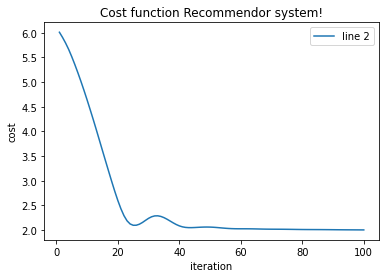

In [220]:
l=np.arange(1,len(c)+1)
plt.plot(l, c, label = "line 2")
  
# naming the x axis -->
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('cost')
# giving a title to my graph
plt.title('Cost function Recommendor system!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

## Prediction

In [245]:
extra_1 = np.exp(-np.matmul(w_1,np.transpose(xtest)))
extra_0 = np.exp(-np.matmul(w_0,np.transpose(xtest)))
extra_neg = np.exp(-np.matmul(w_neg,np.transpose(xtest)))

# extra.shape
temp_1 = 1/(1+extra_1)
temp_0 = 1/(1+extra_0)
temp_neg = 1/(1+extra_neg)
print(temp_1.shape)
yhat = []
o,z,no=0,0,0
a= temp_1.reshape((temp_1.shape[1],)).tolist()
b= temp_0.reshape((temp_0.shape[1],)).tolist()
c= temp_neg.reshape((temp_neg.shape[1],)).tolist()
# print(a)
for i,j,k in zip(a,b,c):
        big = max(i,j,k)
        if(i == big):
            yhat.append(1.0)
            o=o+1
        elif(j == big):
            yhat.append(0.0)
            z=z+1
        elif(k == big):
            yhat.append(-1.0)
            no=no+1
        
print(o,z,no)  

(1, 81490)
13987 43936 23567


In [256]:
# y=pd.DataFrame(y).info()
y=df['category'].fillna(0.0)

y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 162980 entries, 0 to 162979
Series name: category
Non-Null Count   Dtype  
--------------   -----  
162980 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


In [239]:
np.savetxt("w_1.csv", w_1, delimiter=",")
np.savetxt("w_0.csv", w_0, delimiter=",")
np.savetxt("w_neg.csv", w_neg, delimiter=",")


## Acurracy

In [257]:
ytN=np.array(y[int(X.shape[0]*0.5):])
ytest = np.array(ytN)
ytest = np.reshape((ytest),(ytest.shape[0],1))
ytest.shape

(81490, 1)

In [258]:
yhat = np.array(yhat)
yhat=np.reshape((yhat),(yhat.shape[0],1))
yhat.shape

(81490, 1)

In [259]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, yhat)

0.45821573199165544

In [261]:
from sklearn.metrics import f1_score
f1_score(ytest, yhat, average='micro')

0.45821573199165544

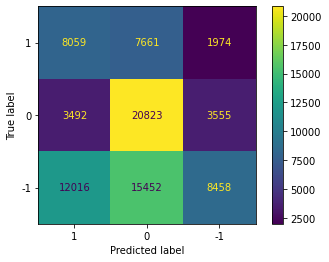

In [263]:
from sklearn.metrics import *

confusion_matrix = confusion_matrix(ytest, yhat)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 0,-1])

cm_display.plot()
plt.show()